# Preamble
## Necessary imports

In [16]:
import sympy
from sympy import pi,cos,sin,cot,sqrt
from dataclasses import dataclass, field
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle,Annulus,Polygon
from matplotlib.collections import PatchCollection
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import matplotlib.patheffects as path_effects
from mpl_toolkits.axisartist.axislines import Axes
from math import pi

from opencolors import colors

## Matplotlib style setup

In [32]:
p = plt.rcParams
# use this on linux
#p["font.sans-serif"] = ["Roboto Condensed"]
p["font.sans-serif"] = ["Nimbus Sans"]
# use this on mac
# p["font.sans-serif"] = ["Helvetica"]
p["font.weight"] = "regular"
p["font.size"] = 15
p["mathtext.fontset"] = "stixsans"
%matplotlib widget

# Encode calo geometry in a class with some useful methods

In [33]:
def get_readout_layers():
    return [15, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35] # mm

@dataclass
class geometry:
    # Inclination angle of the absorbers / readout electrodes
    alpha: float = np.radians(50)
    # thickness of active volume between two absorber plates
    # at barrel Rmin, measured perpendicular to the readout plate
    # TODO this definition is not that precise... check
    lar_double_gap_thickness_rmin: float = 1.239749*2 # mm
    # "air" gap between cryostat vessels
    air_margin_thickness: float = 54 # mm
    # Al solid corresponding to 0.11 X0
    cryo_barrel_front_warm: float = 10 # mm
    # Al soid equivalent to 0.043 X0 sandwich CFRP
    cryo_barrel_front_cold: float = 3.8 # mm
    # Al solid corresponding to 0.34 X0
    cryo_barrel_back_warm: float = 2.7 # mm
    # Al soid equivalent to 0.03 X0 sandwich CFRP
    cryo_barrel_back_cold: float = 30 # mm
    # Al solenoid with thickness of 0.8 X0
    solenoid_barrel: float = 70 # mm
    # guesswork for cryostat sides
    cryo_barrel_side_warm: float = 30 # mm
    cryo_barrel_side_cold: float = 3.8 # mm
    # dead liquid at the front (can we achieve it ?)
    lar_bath_thickness_front: float = 5 # mm
    # dead liquid at the back (used for readout electronics)
    lar_bath_thickness_back: float = 40 # mm
    # Lead thickness (planes absorbers for now... trapezoid to come later)
    pb_thickness: float = 1.8 # mm
    # total amount of steel in one passive plate: it is divided for the outside layer on top and bottom
    steel_thickness: float = 0.1 # mm
    # total amount of glue in one passive plate: it is divided for the outside layer on top and bottom
    glue_thickness: float = 0.1 # mm
    # readout in between two absorber plates
    readout_thickness: float = 1.2 # mm
    # electrode segmentation, done in a weird way
    readout_layers: list[float] = field(default_factory=get_readout_layers)

    # overall dimensions
    bar_ecal_rmin: float = 2100 # mm
    bar_ecal_rmax: float = 2770 # mm
    bar_ecal_dz: float = 3100 # mm
    # dimensions actually used (there is an "air" buffer unused for now)
    bar_cryo_ecal_rmin: float = 0
    bar_cryo_ecal_rmax: float = 0
    bar_cryo_ecal_dz: float = 0
    # dimensions of actual active volume
    embarrel_rmin: float = 0
    embarrel_rmax: float = 0
    embarrel_rcenter: float = 0 # mean between rmin and rmax
    embarrel_dz: float = 0

    # derived quantities
    cryo_barrel_front: float = 0
    cryo_barrel_back: float = 0
    cryo_barrel_side: float = 0
    # actual number of absorbers / readout planes around the barrel. Computed from absorber
    # and readout thicknesses, as well as intended size of double LAr gaps at rmin
    n_planes: int = 0
    # length of absorbers / readout planes
    plane_length: float = 0
    # total absorber thickness
    absorber_thickness: float = 0
    # thickness of one sheet of glue + steel
    sheet_thickness: float = 0
    # angular distance between two absorber planes as seen from the center of the detector
    dphi: float = 0


    def __post_init__(self):
        self.compute_derived_quantities()

    def compute_derived_quantities(self):
        self.cryo_barrel_front = self.cryo_barrel_front_warm + self.cryo_barrel_front_cold
        self.cryo_barrel_back = self.cryo_barrel_back_warm + self.cryo_barrel_back_cold + self.solenoid_barrel
        self.cryo_barrel_side = self.cryo_barrel_side_warm + self.cryo_barrel_side_cold
        self.bar_cryo_ecal_rmin = self.bar_ecal_rmin + self.air_margin_thickness
        self.bar_cryo_ecal_rmax = self.bar_ecal_rmax - self.air_margin_thickness
        self.bar_cryo_ecal_dz = self.bar_ecal_dz
        self.embarrel_rmin = self.bar_cryo_ecal_rmin + self.cryo_barrel_front + self.lar_bath_thickness_front
        self.embarrel_rmax = self.bar_cryo_ecal_rmax - self.cryo_barrel_back - self.lar_bath_thickness_back
        self.embarrel_rcenter = (self.embarrel_rmin + self.embarrel_rmax) / 2
        self.embarrel_dz = self.bar_ecal_dz - self.cryo_barrel_side_cold
        # rmin + l * e^(i a) = rmax * e^(i phi)
        # rmin * e^(-i a) + l = rmax * e^(i (phi - a))
        # rmax^2 = (l + rmin*cos(a))^2 + (rmin*sin(a))^2
        # l = -rmin*cos(a) + sqrt(rmax^2 - (rmin*sin(a))^2)
        self.plane_length = -self.embarrel_rmin*np.cos(self.alpha) + \
                            np.sqrt(np.square(self.embarrel_rmax) -
                                    np.square(self.embarrel_rmin*np.sin(self.alpha)))
        self.absorber_thickness = self.pb_thickness + self.glue_thickness + self.steel_thickness
        self.sheet_thickness = (self.glue_thickness + self.steel_thickness) / 2
        # intended thickness of one full layer at rmin
        total_thickness = self.absorber_thickness + self.readout_thickness + self.lar_double_gap_thickness_rmin
        # this thickness is inclined at an angle alpha-pi/2
        # rmin+some_length*e^(i a)+(thick/2)*e^(i (a+pi/2)) = rmin * e^(i dphi/2)
        # rmin * e^(-i a) + some_length + (thick/2)*i = rmin * e^(i (dphi/2 - a))
        # -rmin*sin(a) + thick/2 = rmin*sin(dphi/2-a)
        # dphi = 2 * (a + asin(thick/(2*rmin) - sin(a)))
        dphi = 2 * (self.alpha + np.arcsin(total_thickness/(2*self.embarrel_rmin) - np.sin(self.alpha)))
        self.n_planes = int((2*np.pi) // dphi)
        self.dphi = (2*np.pi) / self.n_planes

        pass

    def scale_dimensions(self, scale: float):
        self.air_margin_thickness *= scale
        self.cryo_barrel_front_warm *= scale
        self.cryo_barrel_front_cold *= scale
        self.cryo_barrel_back_warm *= scale
        self.cryo_barrel_back_cold *= scale
        self.solenoid_barrel *= scale
        self.cryo_barrel_side_warm *= scale
        self.cryo_barrel_side_cold *= scale
        self.lar_bath_thickness_front *= scale
        self.lar_bath_thickness_back *= scale
        self.bar_ecal_rmin *= scale
        self.bar_ecal_rmax *= scale
        self.bar_ecal_dz *= scale
        self.compute_derived_quantities()

    def scale_thicknesses(self, scale: float):
        self.lar_double_gap_thickness_rmin *= scale
        self.pb_thickness *= scale
        self.steel_thickness *= scale
        self.glue_thickness *= scale
        self.readout_thickness *= scale
        self.compute_derived_quantities()

    @classmethod
    def from_xml(cls, path_to_xml):
        # seems actually quite tough... as xml contains code and formulas everywhere. Can we somehow
        # use the code that interprets the xml from python ?
        return cls()

    def gap_thickness(self, r: float):
        # -rmin*sin(a) + thick/2 = rmin*sin(dphi/2-a)
        halfthickmin = self.embarrel_rmin*(np.sin(self.alpha) + np.sin(self.dphi/2-self.alpha))
        gap_size_min = halfthickmin - self.readout_thickness/2 - self.absorber_thickness/2
        # at rmax, the angle wrt radius is not alpha anymore
        # rmin + l*e^(i a) = rmax*e*(i phi)
        # rmin * sin(a) = rmax * sin(a-phi)
        # b = a - phi = asin(rmin/rmax * sin(a))
        # rmax + thick/2 * e^(i (b+pi/2)) = (rmax - some_length*e^(i b)) * e^(i dphi/2)
        # rmax * e^(-i (b+dphi/2)) + thick/2 * e^(i (pi/2-dphi/2)) = rmax * e^(-i b) - some_length
        # thick/2 * cos(dphi/2) = rmax * (sin(b+dphi/2) - sin(b))
        beta = np.arcsin(self.embarrel_rmin/self.embarrel_rmax * np.sin(self.alpha))
        halfthickmax = self.embarrel_rmax/np.cos(self.dphi/2) * (np.sin(beta+self.dphi/2) - np.sin(beta))
        gap_size_max = halfthickmax - self.readout_thickness/2 - self.absorber_thickness/2

        return (r-self.embarrel_rmin)/(self.embarrel_rmax-self.embarrel_rmin) * (gap_size_max-gap_size_min) + gap_size_min

    def layers_on_electrode(self):
        arr= np.array(self.readout_layers)
        return arr * self.plane_length / arr.sum()

    def layers_radii(self):
        """Boundaries of readout layers as radius from detector center"""
        orig_sizes = np.array([0] + self.readout_layers)
        electrode_sizes = orig_sizes *  self.plane_length / orig_sizes.sum()
        electrode_boundaries = electrode_sizes.cumsum()
        radii = np.sqrt(np.square(self.embarrel_rmin + electrode_boundaries*np.cos(self.alpha)) + \
                        np.square(electrode_boundaries*np.sin(self.alpha)))
        return radii

    def _pos_object(self, r, y, dphi, n):
        pos_0 = np.complex128(self.embarrel_rmin + (r+1j*y)*np.exp(self.alpha*1j))
        pos_n = pos_0*np.exp((dphi+n*self.dphi)*1j)
        return (pos_n.real, pos_n.imag)

    def pos_electrode(self, r, n=0):
        return self._pos_object(r, 0, 0, n)

    def pos_absorber(self, r, n=0):
        return self._pos_object(r, 0, self.dphi/2, n)

    def pos_sheet(self, r, n=0):
        return self._pos_object(r, self.absorber_thickness/2, self.dphi/2, n)

    def pos_gap(self, r, n=0):
        return self._pos_object(r, 0, self.dphi/4, n)

def moving_average(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [34]:
# Create the geometry
geo = geometry()
print(geo)

geometry(alpha=0.8726646259971648, lar_double_gap_thickness_rmin=2.479498, air_margin_thickness=54, cryo_barrel_front_warm=10, cryo_barrel_front_cold=3.8, cryo_barrel_back_warm=2.7, cryo_barrel_back_cold=30, solenoid_barrel=70, cryo_barrel_side_warm=30, cryo_barrel_side_cold=3.8, lar_bath_thickness_front=5, lar_bath_thickness_back=40, pb_thickness=1.8, steel_thickness=0.1, glue_thickness=0.1, readout_thickness=1.2, readout_layers=[15, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35], bar_ecal_rmin=2100, bar_ecal_rmax=2770, bar_ecal_dz=3100, bar_cryo_ecal_rmin=2154, bar_cryo_ecal_rmax=2716, bar_cryo_ecal_dz=3100, embarrel_rmin=2172.8, embarrel_rmax=2573.3, embarrel_rcenter=2373.05, embarrel_dz=3096.2, cryo_barrel_front=13.8, cryo_barrel_back=102.7, cryo_barrel_side=33.8, n_planes=1546, plane_length=565.8599991212948, absorber_thickness=2.0, sheet_thickness=0.1, dphi=0.0040641560848509615)


# Compute inclination angle for projective geometry in phi

## Let's start with some basic geometry
To be replaced later by a proper class holding the geometry

In [35]:
rmin = 217.28 # minimum radius of the active part of the calo
rmax = 257.83 # maximum radius of the active part of the calo
Ne = 1536 # number of planes around phi
n_full_layers = 10
n_planes_crossed_for_PS = 2
n_planes_crossed_per_layer = 4
n_planes_crossed = n_planes_crossed_for_PS + n_full_layers * n_planes_crossed_per_layer

## Actual calculation

In [36]:
km, alpha = sympy.symbols('km alpha')
L = -rmin*cos(alpha) + sqrt(rmax**2 - (rmin*sin(alpha))**2)
Lm = rmin/(sin(alpha) * cot(km*2*pi/Ne) - cos(alpha))
Ltot = Lm.subs(km, n_planes_crossed)
res = sympy.nsolve(L-Ltot, alpha, np.radians(50))
print("Inclination angle for projective geometry is {:.4f} degrees ({:.4f} radians)".format(np.degrees(float(res)), res))
readoutThickness = geometry.readout_thickness
passiveThickness = geometry.absorber_thickness
activeThickness = sin(pi/Ne)*(2.*rmin*10*cos(res)) - passiveThickness - readoutThickness
print("Active thickness = 2*{:.4f} mm".format(activeThickness/2))

Inclination angle for projective geometry is 50.1779 degrees (0.8758 radians)
Active thickness = 2*2.2460 mm


## Let's use this angle to determine the lengths of the layers on the electrode

In [37]:
L_layers_cum = [float(Lm.subs({alpha:res, km:n_planes_crossed_for_PS + m*n_planes_crossed_per_layer})) for m in range(n_full_layers+1)]
L_layers_cum
L_layers = np.diff(L_layers_cum, prepend=[0])
with np.printoptions(precision=2, suppress=True):
    print("Lengths of layers on the electrode (cm)")
    print(L_layers)
    scaling_factor = (rmax-rmin) / L_layers_cum[-1]
    print("Lengths of layers scaled to calo depth (cm)")
    print("i.e what you should put in the calo xml file")
    print(L_layers*scaling_factor)

Lengths of layers on the electrode (cm)
[2.33 4.76 4.9  5.05 5.2  5.37 5.55 5.74 5.94 6.16 6.4 ]
Lengths of layers scaled to calo depth (cm)
i.e what you should put in the calo xml file
[1.65 3.36 3.46 3.56 3.68 3.79 3.92 4.05 4.2  4.35 4.52]


# Plot of gap thickess

In [38]:
def plot_gap_thickness(geo):
    r = np.linspace(geo.embarrel_rmin, geo.embarrel_rmax)
    gap = geo.gap_thickness(r)
    fig, ax = plt.subplots()
    twin = ax.twiny()
    ax.plot(r, gap, '-', color=colors['cyan'][5], linewidth=3)
    ax.set_ylim(bottom=0, top=2.5)
    ax.set_ylabel("LAr gap thickness (mm)")
    twin.set_xlim(ax.get_xlim())

    # make right and top axis invisible
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    twin.spines.right.set_visible(False)
    twin.spines.top.set_visible(False)

    # play with x axis
    radii = geo.layers_radii()
    labels_locs = moving_average(radii)
    labels = [str(i) for i in range(len(labels_locs))]
    twin.spines.bottom.set_bounds(r.min(), r.max())
    twin.spines.bottom.set_position(("axes", 0.2))
    twin.xaxis.set_ticks(radii)
    twin.xaxis.set_ticks(labels_locs, labels=labels, minor=True)
    twin.xaxis.set_major_formatter(ticker.NullFormatter())
    twin.xaxis.set_tick_params(which='minor', length=0)
    twin.xaxis.tick_bottom()
    twin.xaxis.set_label_position("bottom")
    twin.set_xlabel("Layers")

    for i in range(len(radii)//2):
        ax.axvspan(radii[2*i], radii[2*i+1], color=colors['gray'][1], zorder=-50)
    ax.set_xlabel("Radius (mm)")
    fig.tight_layout()
    return fig, ax

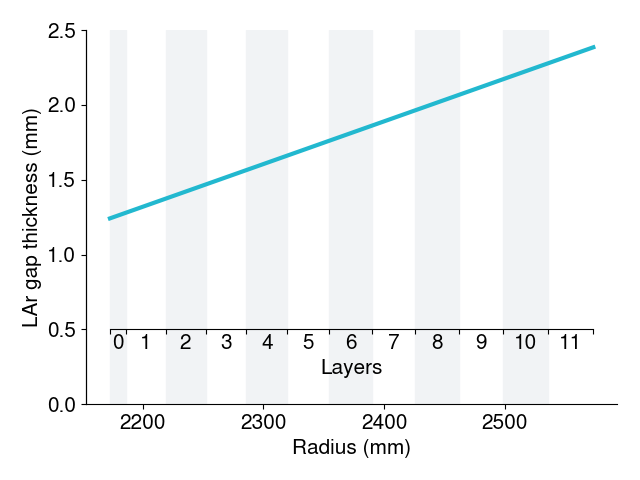

In [39]:
fig, ax = plot_gap_thickness(geo=geo)
plt.show()

# Sketches of the calorimeter concept

In [40]:
def plot_design(geo, show='full'):
    """Main calo design sketch

    show: which part of the design to show. Can be 'full', 'quadrant', 'sketch' or (x1, y1, x2, y2).

    """
    fig = plt.figure(figsize=(10,10), tight_layout=True)
    ax = plt.subplot(1, 1, 1, aspect=1)

    absorbers = []
    sheets = []
    fillers = []
    electrodes = []

    layers = geo.layers_on_electrode()

    for i in range(geo.n_planes):
        # we create rectangles at phi=0 with 50deg angle, then we rotate them by the correct amount
        t_el = transforms.Affine2D().rotate(i*geo.dphi)
        r_el = Rectangle((geo.embarrel_rmin, -geo.readout_thickness/2), geo.plane_length,
                geo.readout_thickness, angle=np.degrees(geo.alpha), rotation_point=(geo.embarrel_rmin, 0),
                transform=t_el)
        electrodes.append(r_el)
        t_abs = transforms.Affine2D().rotate((i+1/2)*geo.dphi)
        r_abs = Rectangle((geo.embarrel_rmin+layers[0], -geo.pb_thickness/2),
                geo.plane_length-layers[0], geo.pb_thickness, angle=np.degrees(geo.alpha),
                rotation_point=(geo.embarrel_rmin, 0), transform=t_abs)
        absorbers.append(r_abs)
        r_fill = Rectangle((geo.embarrel_rmin, -geo.pb_thickness/2), layers[0], geo.pb_thickness,
                angle=np.degrees(geo.alpha), rotation_point=(geo.embarrel_rmin, 0), transform=t_abs)
        fillers.append(r_fill)
        r_sheet1 = Rectangle((geo.embarrel_rmin, -geo.absorber_thickness/2),
                geo.plane_length, geo.sheet_thickness, angle=np.degrees(geo.alpha),
                rotation_point=(geo.embarrel_rmin, 0), transform=t_abs)
        r_sheet2 = Rectangle((geo.embarrel_rmin, +geo.pb_thickness/2),
                geo.plane_length, geo.sheet_thickness, angle=np.degrees(geo.alpha),
                rotation_point=(geo.embarrel_rmin, 0), transform=t_abs)
        sheets.append(r_sheet1)
        sheets.append(r_sheet2)

    lar_front = geo.bar_cryo_ecal_rmin + geo.cryo_barrel_front
    lar_back = geo.bar_cryo_ecal_rmax - geo.cryo_barrel_back

    lar_bath = Annulus((0, 0), lar_back, width = lar_back - lar_front, color=colors['cyan'][2])

    cryo_front_cold = Annulus((0, 0), lar_front, width = geo.cryo_barrel_front_cold)
    # cheat a bit on this placement
    cryo_front_warm = Annulus((0, 0), geo.bar_ecal_rmin + geo.cryo_barrel_front_warm,
            width = geo.cryo_barrel_front_warm)
    cryo_back_cold = Annulus((0, 0), lar_back+geo.cryo_barrel_back_cold, width = geo.cryo_barrel_back_cold)
    cryo_back_warm = Annulus((0, 0), geo.bar_cryo_ecal_rmax, width = geo.cryo_barrel_back_warm)
    cryo_walls = [cryo_front_cold, cryo_front_warm, cryo_back_cold, cryo_back_warm]

    solenoid = Annulus((0, 0), geo.bar_cryo_ecal_rmax-geo.cryo_barrel_back_warm, width = geo.solenoid_barrel,
            color=colors['orange'][3])

    #envelope = Annulus((0, 0), geo.bar_ecal_rmax, width = geo.bar_ecal_rmax - geo.bar_ecal_rmin,
            #edgecolor='black', linestyle='--', facecolor='w')

    #ax.add_artist(envelope)
    ax.add_artist(lar_bath)
    ax.add_artist(solenoid)

    pc_absorbers = PatchCollection(absorbers, color=colors['gray'][4]) #, alpha=0.4)
    pc_electrodes = PatchCollection(electrodes, color=colors['green'][4])
    pc_cryo = PatchCollection(cryo_walls, color=colors['gray'][2])
    pc_fillers = PatchCollection(fillers, color=colors['gray'][1])
    pc_sheets = PatchCollection(sheets, color=colors['gray'][5])
    ax.add_collection(pc_cryo)
    ax.add_collection(pc_absorbers)
    ax.add_collection(pc_fillers)
    ax.add_collection(pc_sheets)
    ax.add_collection(pc_electrodes)

    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    if show == 'quadrant':
            ax.set_xlim(0, geo.bar_ecal_rmax)
            ax.set_ylim(0, geo.bar_ecal_rmax)
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
    elif show == 'full':
            ax.set_xlim(-geo.bar_ecal_rmax, geo.bar_ecal_rmax)
            ax.set_ylim(-geo.bar_ecal_rmax, geo.bar_ecal_rmax)
            ax.spines.bottom.set_position(('data',0))
            ax.spines.left.set_position(('data',0))
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            for label in ax.get_xticklabels():
                label.set_path_effects(
                        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])
            for label in ax.get_yticklabels():
                label.set_path_effects(
                        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])

    elif type(show) is tuple:
            (x1, y1, x2, y2) = show
            ax.set_xlim(x1, x2)
            ax.set_ylim(y1, y2)

    elif show == 'sketch':
            @ticker.FuncFormatter
            def major_formatter(x, pos):
                return f'{x/10:.1f} cm'
            ax.set_xlim(1700, 2780)
            ax.set_ylim(0, 600)
            ax.set_xlabel('')
            ax.yaxis.set_visible(False)
            ax.spines[['left', 'right', 'top']].set_visible(False)
            ax.xaxis.set_major_formatter(major_formatter)
            ax.xaxis.set_major_locator(ticker.FixedLocator([geo.bar_ecal_rmin,
                geo.embarrel_rmin, geo.embarrel_rmax, geo.bar_ecal_rmax]))
            ax.tick_params(labelsize='x-small')

            xtext = 1800
            xbend = 2030
            def my_annotate(text, xy, ytext):
                t = ax.annotate("", xy=xy, xytext=(xbend, ytext),
                        arrowprops=dict(
                            arrowstyle="->",
                            color="black",
                            shrinkA=0,
                            shrinkB=0,
                            linewidth=1.25,
                            )
                        )
                t.arrow_patch.set_path_effects(
                        [path_effects.Stroke(linewidth=5, foreground="white"), path_effects.Normal()]
                        )
                t = ax.annotate(text, xy=(xbend, ytext), xytext=(xtext, ytext),
                        va='center',
                        arrowprops=dict(
                            arrowstyle="-",
                            color="black",
                            linewidth=1.25,
                            shrinkA=0,
                            shrinkB=0.1,
                            relpos=(1, 0.5),
                            )
                        )

            my_annotate("Steel sheet", xy=geo.pos_sheet(200, 8), ytext=500)
            my_annotate("Lead absorber", xy=geo.pos_absorber(150, 8), ytext=450)
            my_annotate("Filler (pre-sampler)", xy=geo.pos_absorber(10, 9), ytext=400)
            my_annotate("Noble liquid", xy=geo.pos_gap(80, 8), ytext=350)
            my_annotate("Readout electrode", xy=geo.pos_electrode(50, 8), ytext=300)

    fig.tight_layout()
    return fig, ax

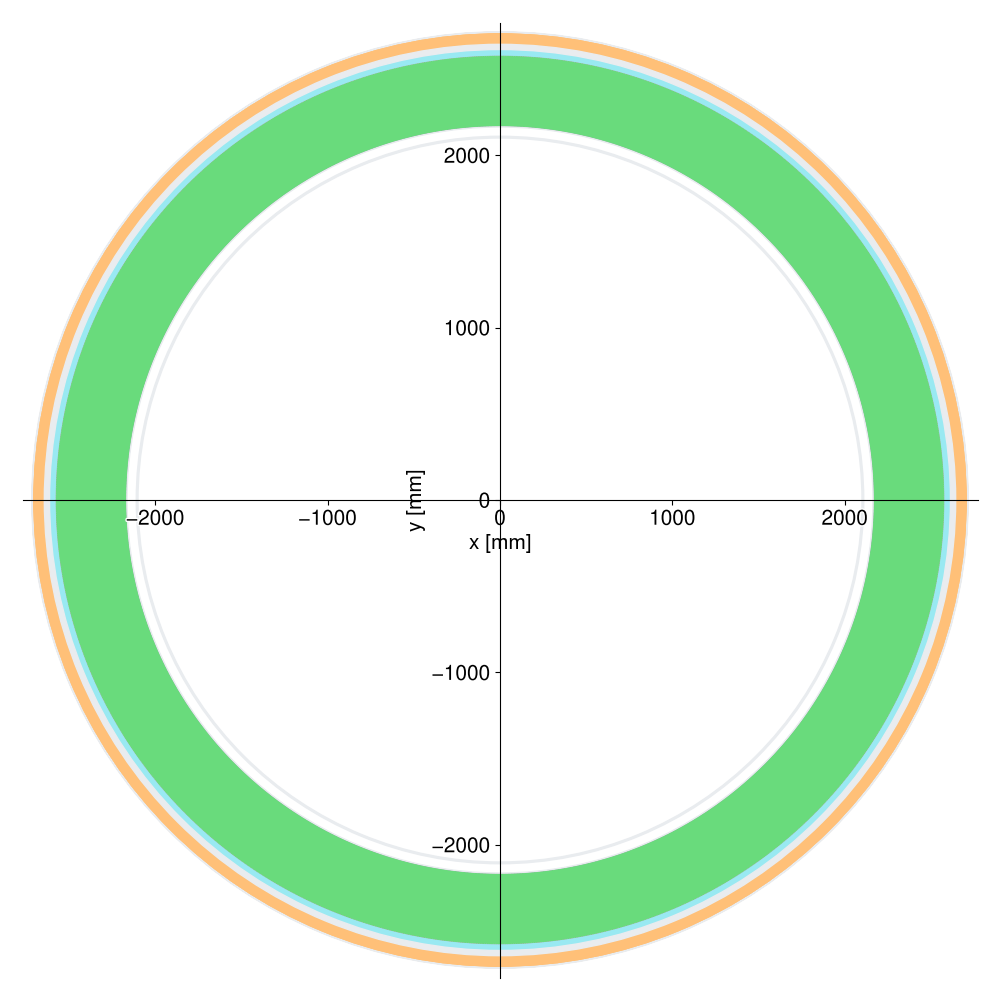

In [41]:
fig, ax = plot_design(geo, show='full')
plt.show()

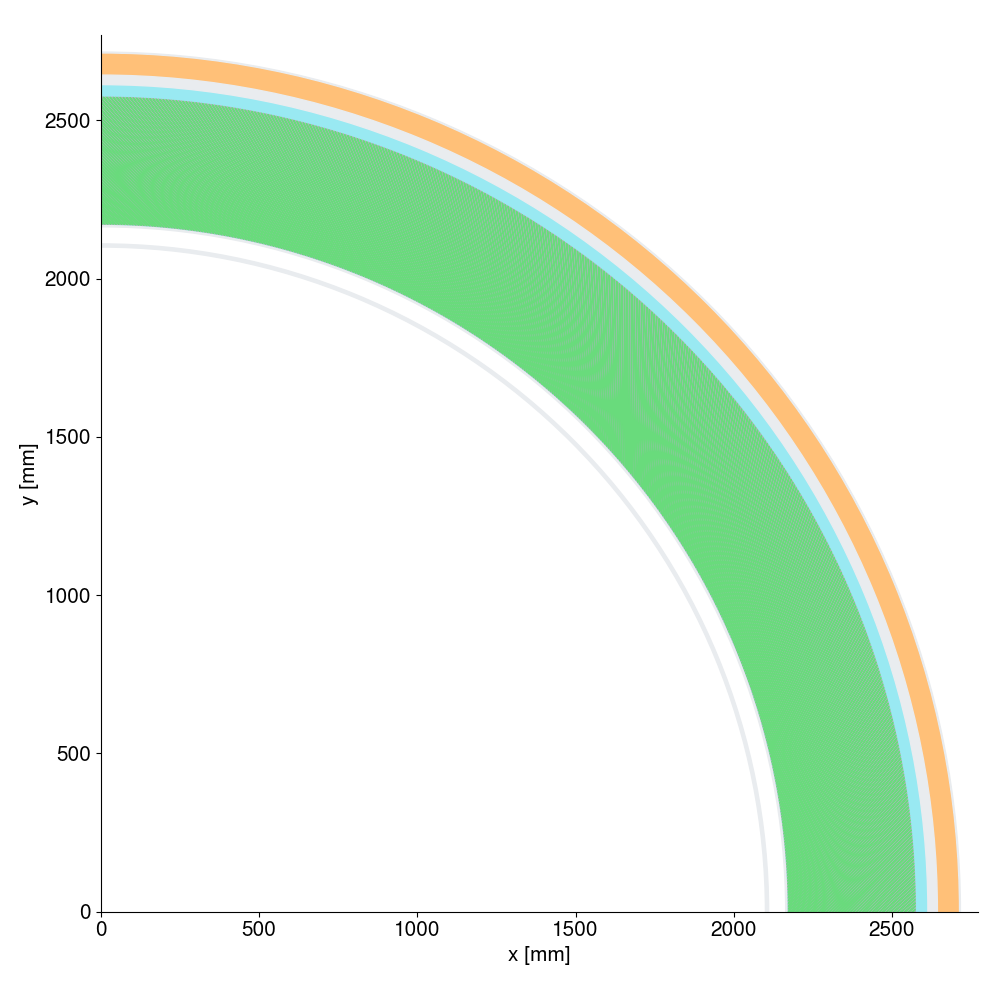

In [42]:
fig, ax = plot_design(geo, show='quadrant')
plt.show()

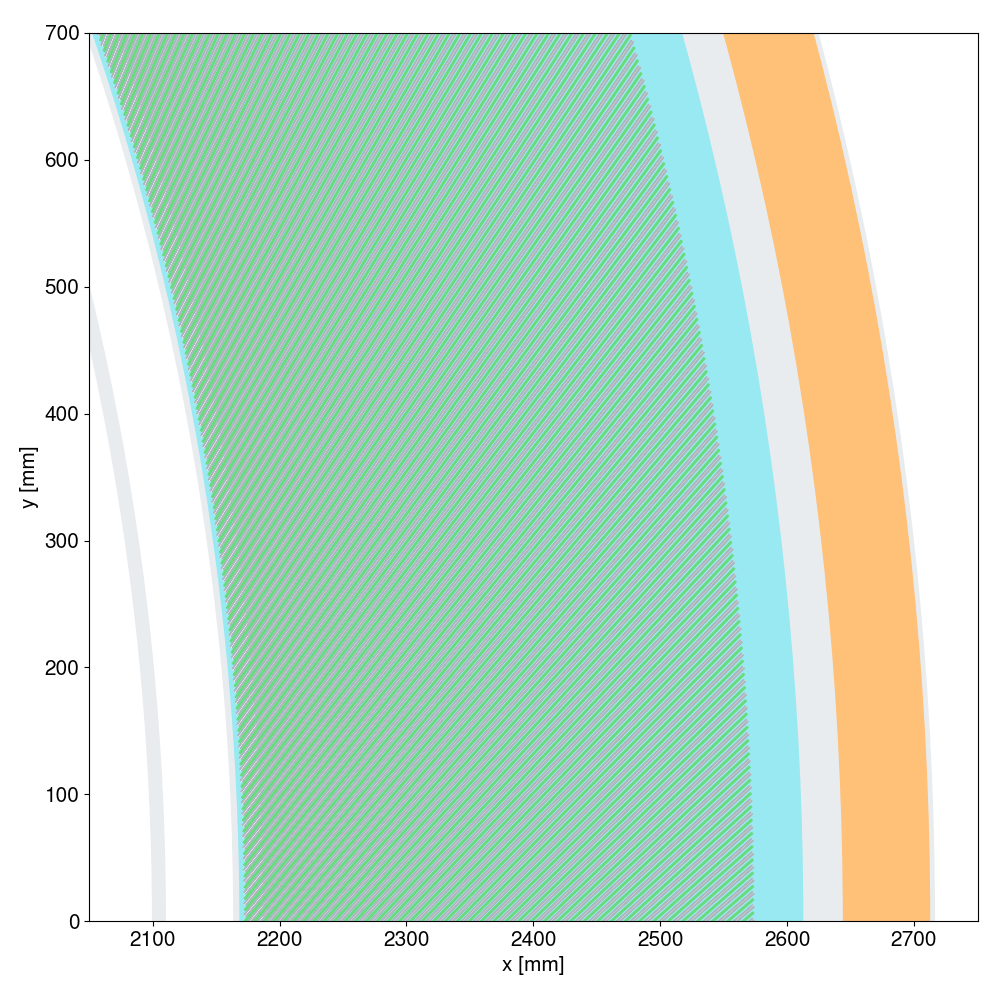

In [43]:
fig, ax = plot_design(geo, show=(2050, 0, 2750, 700))
plt.show()

In [44]:
geo.scale_thicknesses(5.)

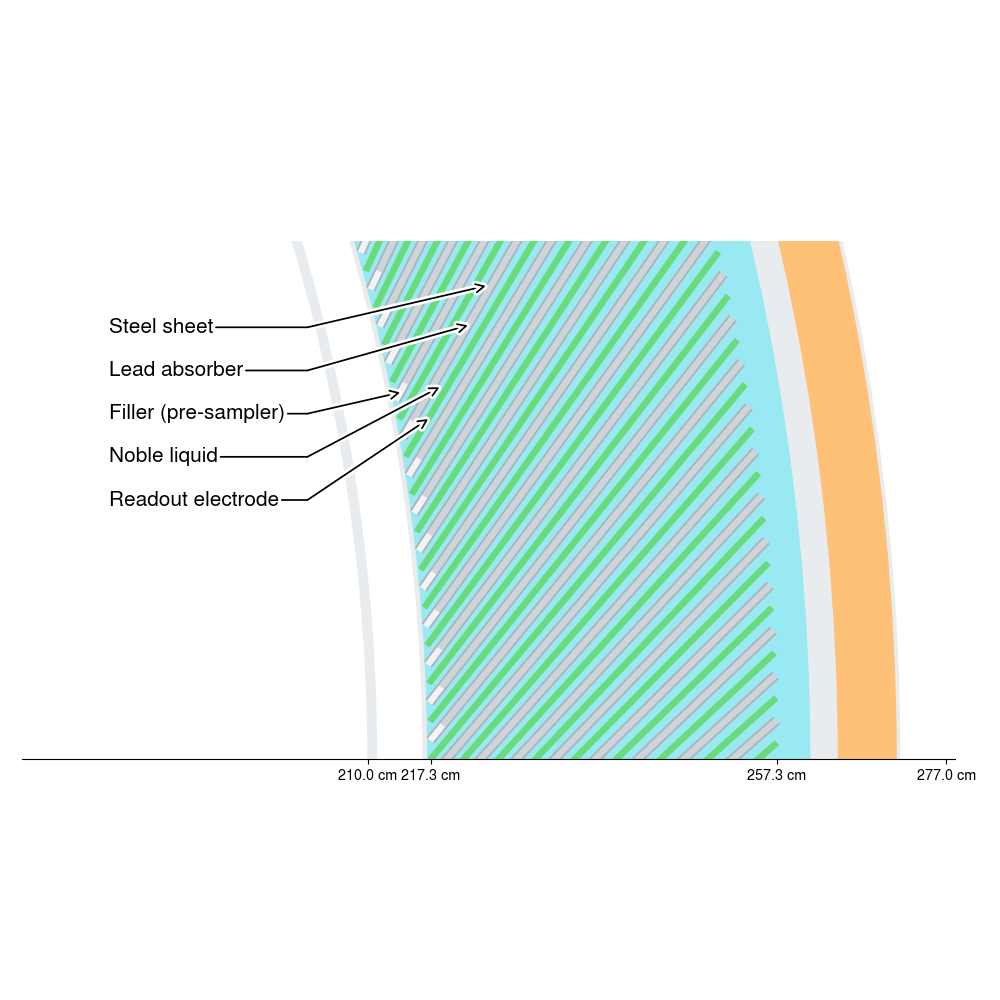

In [45]:
plot_design(geo, show='sketch')
plt.show()